In [ ]:
import torch
from diffusers import AutoModel, Flux2Pipeline, AutoencoderKLFlux2

device = torch.device("cuda")
# tiny_vae = AutoModel.from_pretrained(
#     "fal/FLUX.2-Tiny-AutoEncoder", trust_remote_code=True, torch_dtype=torch.bfloat16
# ).to(device)


class DotDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


class Flux2TinyAutoEncoder(AutoencoderKLFlux2):
    def __init__(self):
        super().__init__()
        self.vae = AutoModel.from_pretrained(
            "fal/FLUX.2-Tiny-AutoEncoder",
            trust_remote_code=True,
            torch_dtype=torch.bfloat16,
        ).to("cuda")

        # self._internal_dict = self.vae.config

    def encode(self, x):
        x = torch.nn.functional.pixel_shuffle(self.vae.encode(x).latent, 2)
        return DotDict(latent_dist=DotDict(mode=lambda: x))

    def decode(self, x, return_dict=True):
        if return_dict:
            return DotDict(
                sample=self.vae.decode(
                    torch.nn.functional.pixel_unshuffle(x, 2)
                ).sample.unsqueeze(0)
            )
        return self.vae.decode(
            torch.nn.functional.pixel_unshuffle(x, 2)
        ).sample.unsqueeze(0)


tiny_vae = Flux2TinyAutoEncoder().to(torch.bfloat16)

/code/auto_remaster/sandbox/DiffSynth-Studio/.venv_diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipping import of cpp extensions due to incompatible torch version 2.10.0+cu128 for torchao version 0.15.0             Please see https://github.com/pytorch/ao/issues/2919 for more info
/code/auto_remaster/sandbox/DiffSynth-Studio/.venv_diff/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
`trust_remote_code` is enabled. Downloading code from fal/FLUX.2-Tiny-AutoEncoder. Please ensure you trust the contents of this repository
The config attributes {'auto_map': {'AutoModel': 'flux2_tiny_autoencoder.Flux

In [2]:
tiny_vae.vae.config.scaling_factor
tiny_vae.dtype

torch.bfloat16

In [ ]:
import torch
from diffusers import Flux2Pipeline, Flux2KleinPipeline
from torchao.float8 import Float8LinearConfig, convert_to_float8_training


def module_filter_fn(mod: torch.nn.Module, fqn: str):
    # don't convert the output module
    if fqn == "proj_out":
        return False
    # don't convert linear modules with weight dimensions not divisible by 16
    if isinstance(mod, torch.nn.Linear):
        if mod.in_features % 16 != 0 or mod.out_features % 16 != 0:
            return False
    return True


model_name = "black-forest-labs/FLUX.2-klein-base-4B"
# model_name = "black-forest-labs/FLUX.2-klein-base-9B"
pipeline = Flux2KleinPipeline.from_pretrained(
    model_name,
    # torch_dtype=torch.bfloat16,
    torch_dtype=torch.float16,
)
# pipeline = Flux2Pipeline.from_pretrained(
#     "black-forest-labs/FLUX.2-klein-base-4B",
#     vae=tiny_vae,
#     torch_dtype=torch.bfloat16,
# ).to(device)


convert_to_float8_training(
    pipeline.transformer,
    module_filter_fn=module_filter_fn,
    config=Float8LinearConfig(pad_inner_dim=True),
)
pipeline.load_lora_weights(
    # "auto_remaster/sandbox/diffusers_flux2/outputs/render_nfs_4screens_6_sdxl_1_wan_mix_noise_lora_1_4B/checkpoint-500/",
    "auto_remaster/sandbox/diffusers_flux2/outputs/nfs_pix2pix_1920_1080_v6_upscale_2x_raw_filtered_noise_lora_1_4B/checkpoint-8000",
    # "auto_remaster/sandbox/diffusers_flux2/outputs/nfs_pix2pix_1920_1080_v6_upscale_2x_raw_filtered_lora_noise_3_4B/checkpoint-10000",
    weight_name="pytorch_lora_weights.safetensors",
    adapter_name="my_first_lora_v5",
)

pipeline = pipeline.to("cuda")

/code/auto_remaster/sandbox/DiffSynth-Studio/.venv_diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipping import of cpp extensions due to incompatible torch version 2.10.0+cu128 for torchao version 0.15.0             Please see https://github.com/pytorch/ao/issues/2919 for more info
Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


In [10]:
pipeline.fuse_lora(lora_scale=1.0)
pipeline.unload_lora_weights()

In [1]:
from datasets import load_dataset
import datasets
dataset = load_dataset(
    "imagefolder",
    data_dir="/code/auto_remaster/sandbox/diffusers_flux2/dataset/nfs_pix2pix_1920_1080_v6",
    # features=datasets.Features(
	# 	input_image_file_name=datasets.Value('string'),
	# 	edit_prompt=datasets.Value('string'),
	# 	edited_image_file_name=datasets.Value('string'),
	# )
)

/code/auto_remaster/sandbox/DiffSynth-Studio/.venv_diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'input_image_file_name': Value('large_string'), 'edit_prompt': Value('large_string'), 'edited_image_file_name': Value('large_string')}


Generating train split: 4 examples [00:00, 643.32 examples/s]


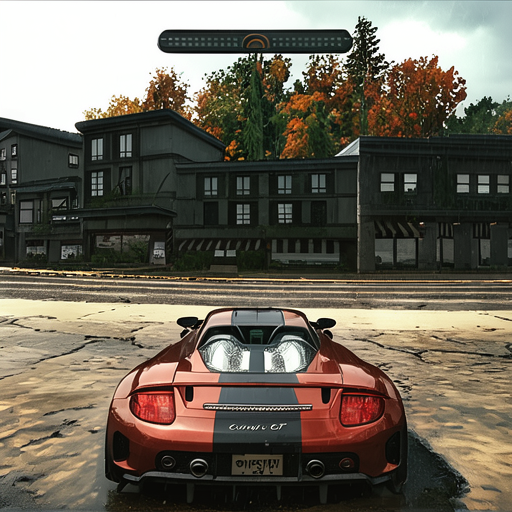

In [4]:
dataset['train'][0]['edited_image']

In [2]:
from datasets import load_dataset

# dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v5_upscale_2x_raw"
dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
# dataset_name = "dim/render_nfs_4screens_6_sdxl_1_wan_mix"
# dataset_name = "dim/render_nfs_4screens_5_sdxl_1_wan_mix"
dataset = load_dataset(
    dataset_name,
    cache_dir=f"/code/dataset/{dataset_name.split('/')[-1]}",
)
# dataset["train"] = dataset["train"].shuffle(seed=2025)
dataset = dataset["train"]

In [3]:
dataset

Dataset({
    features: ['input_image', 'edit_prompt', 'edited_image'],
    num_rows: 49424
})

In [4]:
# 3. Подготовка трансформаций
from torchvision import transforms
import torch

# weight_dtype = torch.bfloat16
weight_dtype = torch.float16
# weight_dtype = torch.float32
device = "cuda"
resolution = 512
# resolution = 768
valid_transforms = transforms.Compose(
    [
        transforms.Resize(
            resolution,
            interpolation=transforms.InterpolationMode.LANCZOS,
        ),
        transforms.CenterCrop(resolution),
    ]
)
train_transforms = transforms.Compose(
    [
        transforms.Resize(
            resolution,
            interpolation=transforms.InterpolationMode.LANCZOS,
        ),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5),
        ),
    ]
)
prompt_embeds = torch.load(
    # "auto_remaster/sandbox/diffusers_flux2/outputs/render_nfs_4screens_6_sdxl_1_wan_mix_noise_lora_1_4B/prompt_embeds.pt"
    "auto_remaster/sandbox/diffusers_flux2/outputs/nfs_pix2pix_1920_1080_v6_upscale_2x_raw_filtered_noise_lora_1_4B/prompt_embeds.pt"
    # "auto_remaster/sandbox/diffusers_flux2/outputs/nfs_pix2pix_1920_1080_v6_upscale_2x_raw_filtered_lora_noise_3_4B/prompt_embeds.pt"
)
prompt_embeds = prompt_embeds.to(weight_dtype).to("cuda")

In [8]:
# from PIL import Image
# Image.open('photo_2026-02-10_21-52-51.jpg').convert('RGB')

In [9]:
pipeline.vae.dtype

torch.float16

100%|██████████| 30/30 [00:02<00:00, 13.79it/s]



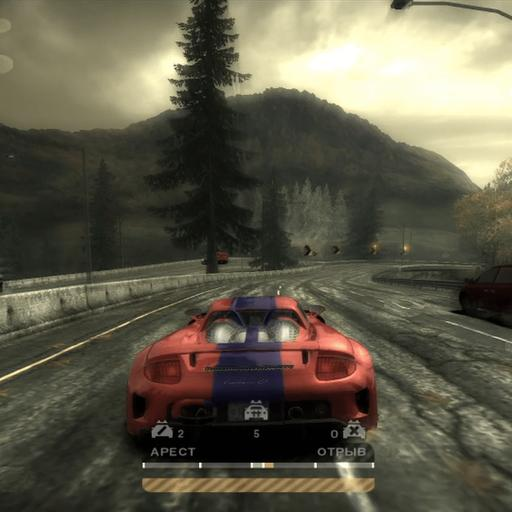
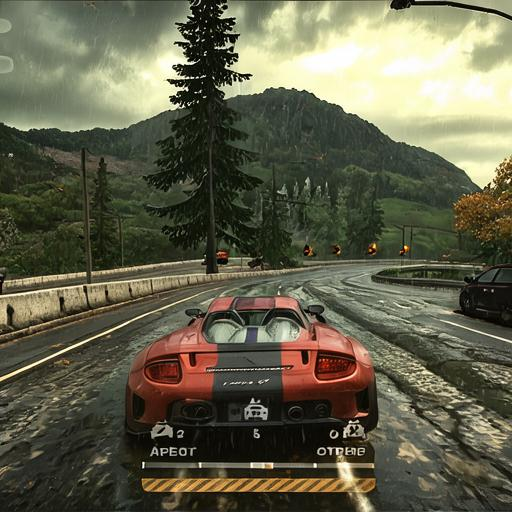

In [13]:
def create_frequency_soft_cutoff_mask(
    height: int,
    width: int,
    cutoff_radius: float,
    transition_width: float = 5.0,
    device: torch.device = None,
) -> torch.Tensor:
    """
    Create a smooth frequency cutoff mask for low-pass filtering.

    Args:
        height: Image height
        width: Image width
        cutoff_radius: Frequency cutoff radius (0 = no structure, max_radius = full structure)
        transition_width: Width of smooth transition (smaller = sharper cutoff)
        device: Device to create tensor on

    Returns:
        torch.Tensor: Frequency mask of shape (height, width)
    """
    if device is None:
        device = torch.device("cpu")

    # Create frequency coordinates
    u = torch.arange(height, device=device)
    v = torch.arange(width, device=device)
    u, v = torch.meshgrid(u, v, indexing="ij")

    # Calculate distance from center
    center_u, center_v = height // 2, width // 2
    frequency_radius = torch.sqrt((u - center_u) ** 2 + (v - center_v) ** 2)

    # Create smooth transition mask
    mask = torch.exp(
        -((frequency_radius - cutoff_radius) ** 2) / (2 * transition_width**2)
    )
    mask = torch.where(frequency_radius <= cutoff_radius, torch.ones_like(mask), mask)

    return mask


def clip_frequency_magnitude(noise_magnitudes, clip_percentile=0.95):
    """Clip frequency domain magnitude to prevent large values."""

    # Calculate clipping threshold
    clip_threshold = torch.quantile(noise_magnitudes, clip_percentile)

    # Clip large values
    clipped_magnitudes = torch.clamp(noise_magnitudes, max=clip_threshold)

    return clipped_magnitudes


def generate_structured_noise_batch_vectorized(
    image_batch: torch.Tensor,
    noise_std: float = 1.0,
    pad_factor: float = 1.5,
    cutoff_radius: float = None,
    transition_width: float = 2.0,
    input_noise: torch.Tensor = None,
    sampling_method: str = "fft",
) -> torch.Tensor:
    """
    Generate structured noise for a batch of images using frequency soft cutoff.
    Reduces boundary artifacts by padding images before FFT processing.

    Args:
        image_batch: Batch of image tensors of shape (B, C, H, W)
        noise_std: Standard deviation for Gaussian noise
        pad_factor: Padding factor (1.5 = 50% padding, 2.0 = 100% padding)
        cutoff_radius: Frequency cutoff radius (None = auto-calculate)
        transition_width: Width of smooth transition for frequency cutoff
        input_noise: Optional input noise tensor to use instead of generating new noise.
        sampling_method: Method to sample noise magnitude ('fft', 'cdf', 'two-gaussian')

    Returns:
        torch.Tensor: Batch of structured noise tensors of shape (B, C, H, W)
    """
    assert sampling_method in ["fft", "cdf", "two-gaussian"]
    # Ensure tensor is on the correct device
    batch_size, channels, height, width = image_batch.shape
    dtype = image_batch.dtype
    device = image_batch.device
    image_batch = image_batch.float()

    # Calculate padding size for overlap-add method
    pad_h = int(height * (pad_factor - 1))
    pad_h = pad_h // 2 * 2  # make it even
    pad_w = int(width * (pad_factor - 1))
    pad_w = pad_w // 2 * 2  # make it even

    # Pad images with reflection to reduce boundary artifacts
    padded_images = torch.nn.functional.pad(
        image_batch,
        (pad_w // 2, pad_w // 2, pad_h // 2, pad_h // 2),
        mode="reflect",  # Mirror edges for natural transitions
    )

    # Calculate padded dimensions
    padded_height = height + pad_h
    padded_width = width + pad_w

    # Create frequency soft cutoff mask only if cutoff_radius is provided
    if cutoff_radius is not None:
        cutoff_radius = min(min(padded_height / 2, padded_width / 2), cutoff_radius)
        freq_mask = create_frequency_soft_cutoff_mask(
            padded_height, padded_width, cutoff_radius, transition_width, device
        )
    else:
        # No cutoff - preserve all frequencies (full structure preservation)
        freq_mask = torch.ones(padded_height, padded_width, device=device)

    # Apply 2D FFT to padded images
    fft = torch.fft.fft2(padded_images, dim=(-2, -1))

    # Shift zero frequency to center
    fft_shifted = torch.fft.fftshift(fft, dim=(-2, -1))

    # Extract phase and magnitude for all images
    image_phases = torch.angle(fft_shifted)
    image_phases = clip_frequency_magnitude(image_phases)
    image_magnitudes = torch.abs(fft_shifted)

    if input_noise is not None:
        # Use provided noise
        noise_batch = torch.nn.functional.pad(
            input_noise,
            (pad_w // 2, pad_w // 2, pad_h // 2, pad_h // 2),
            mode="reflect",  # Mirror edges for natural transitions
        )
        noise_batch = noise_batch.float()
    else:
        # Generate Gaussian noise for the padded size
        noise_batch = torch.randn_like(padded_images)

    # Extract noise magnitude and phase
    if sampling_method == "fft":
        # Apply 2D FFT to noise batch
        noise_fft = torch.fft.fft2(noise_batch, dim=(-2, -1))
        noise_fft_shifted = torch.fft.fftshift(noise_fft, dim=(-2, -1))

        noise_magnitudes = torch.abs(noise_fft_shifted)
        noise_phases = torch.angle(noise_fft_shifted)
    elif sampling_method == "cdf":
        # The magnitude of FFT of Gaussian noise follows a Rayleigh distribution.
        # We can sample it directly.
        # The scale of the Rayleigh distribution is related to the std of the Gaussian noise
        # and the size of the FFT.
        # For an N-point FFT of Gaussian noise with variance sigma^2, the variance of
        # the real and imaginary parts of the FFT coefficients is N*sigma^2.
        # The scale parameter for the Rayleigh distribution is sqrt(N*sigma^2 / 2).
        # Here, N = padded_height * padded_width.

        N = padded_height * padded_width
        rayleigh_scale = (N / 2) ** 0.5

        ## Sample from a standard Rayleigh distribution (scale=1) and then scale it.
        uu = torch.rand(size=image_magnitudes.shape, device=device)
        noise_magnitudes = rayleigh_scale * torch.sqrt(-2.0 * torch.log(uu))
        if input_noise is not None:
            noise_fft = torch.fft.fft2(noise_batch, dim=(-2, -1))
            noise_fft_shifted = torch.fft.fftshift(noise_fft, dim=(-2, -1))

            noise_magnitudes = torch.abs(noise_fft_shifted)
            noise_phases = torch.angle(noise_fft_shifted)
        else:
            noise_phases = (
                torch.rand(size=image_magnitudes.shape, device=device) * 2 * torch.pi
                - torch.pi
            )
    elif sampling_method == "two-gaussian":
        N = padded_height * padded_width
        rayleigh_scale = (N / 2) ** 0.5
        # A standard Rayleigh can be generated from two standard normal distributions.
        u1 = torch.randn_like(image_magnitudes)
        u2 = torch.randn_like(image_magnitudes)
        noise_magnitudes = rayleigh_scale * torch.sqrt(u1**2 + u2**2)
        if input_noise is not None:
            noise_fft = torch.fft.fft2(noise_batch, dim=(-2, -1))
            noise_fft_shifted = torch.fft.fftshift(noise_fft, dim=(-2, -1))

            noise_magnitudes = torch.abs(noise_fft_shifted)
            noise_phases = torch.angle(noise_fft_shifted)
        else:
            noise_phases = (
                torch.rand(size=image_magnitudes.shape, device=device) * 2 * torch.pi
                - torch.pi
            )
    else:
        raise ValueError(f"Unknown sampling method: {sampling_method}")

    noise_magnitudes = clip_frequency_magnitude(noise_magnitudes)

    # Scale noise magnitude by standard deviation
    noise_magnitudes = noise_magnitudes * noise_std

    # Apply frequency soft cutoff to mix phases
    # Low frequencies (within cutoff) use image phase, high frequencies use noise phase
    mixed_phases = (
        freq_mask.unsqueeze(0).unsqueeze(0) * image_phases
        + (1 - freq_mask.unsqueeze(0).unsqueeze(0)) * noise_phases
    )

    # Combine magnitude and mixed phase for all images
    fft_combined = noise_magnitudes * torch.exp(1j * mixed_phases)
    # Shift zero frequency back to corner
    fft_unshifted = torch.fft.ifftshift(fft_combined, dim=(-2, -1))
    # Apply inverse FFT
    structured_noise_padded = torch.fft.ifft2(fft_unshifted, dim=(-2, -1))
    # Take real part
    structured_noise_padded = torch.real(structured_noise_padded)

    clamp_mask = (structured_noise_padded < -5) + (structured_noise_padded > 5)
    clamp_mask = (clamp_mask > 0).float()

    structured_noise_padded = (
        structured_noise_padded * (1 - clamp_mask) + noise_batch * clamp_mask
    )

    # Crop back to original size (remove padding)
    structured_noise_batch = structured_noise_padded[
        :, :, pad_h // 2 : pad_h // 2 + height, pad_w // 2 : pad_w // 2 + width
    ]
    return structured_noise_batch.to(dtype)


# pos = 1000
pos = 10000
# pos = 10100
# pos = 10200
# pos = 10300
# pos = 10400
# pos = 10450
# pos = 10550
# pos = 10650
# pos = 31050
item = dataset[pos]
source_image_name = "input_image"
target_image_name = "edited_image"
# Подготовка исходных изображений для визуализации и метрик

orig_source_pil = item[source_image_name].convert("RGB")
target_pil = item[target_image_name].convert("RGB")

source_tensor = valid_transforms(orig_source_pil)
target_tensor = valid_transforms(target_pil)

c_t = train_transforms(orig_source_pil).unsqueeze(0).cuda()
# source_tensor


with torch.no_grad():
    img_tensor = transforms.ToTensor()(source_tensor)
    img_tensor = (img_tensor - 0.5) / 0.5
    img_tensor = img_tensor.unsqueeze(0).to(pipeline.vae.dtype).to("cuda")
    # z_source = pipeline.vae.encode(img_tensor).latent_dist.mode()
    z_source = pipeline.vae.encode(img_tensor).latent_dist.mode()
    z_source = z_source.to(device="cuda", dtype=weight_dtype)

    noise_spatial = generate_structured_noise_batch_vectorized(
        z_source.float(),
        # cutoff_radius=100,
        cutoff_radius=1200,
        # cutoff_radius=50,
    ).to(dtype=weight_dtype, device="cuda")

    # Patchify latents
    latents = pipeline._patchify_latents(noise_spatial).to(weight_dtype)

    prompt = "make this image photorealistic"
    image = pipeline(
        # prompt=prompt,
        prompt_embeds=prompt_embeds.to(weight_dtype),
        image=source_tensor,
        latents=latents,
        guidance_scale=1.0,
        # guidance_scale=2.0,
        # num_inference_steps=50,
        num_inference_steps=30,
        # num_inference_steps=10,
        generator=torch.Generator(device="cuda").manual_seed(0),
    ).images[0]
# image
from jupyter_compare_view import compare

compare(
    # target_tensor,
    source_tensor,
    image,
    cmap="gray",
    start_mode="horizontal",
    start_slider_pos=0.73,
)

In [11]:
pipeline.transformer.transformer_blocks[0]

OptimizedModule(
  (_orig_mod): Flux2TransformerBlock(
    (norm1): LayerNorm((3072,), eps=1e-06, elementwise_affine=False)
    (norm1_context): LayerNorm((3072,), eps=1e-06, elementwise_affine=False)
    (attn): Flux2Attention(
      (to_q): lora.Linear(
        (base_layer): Linear(in_features=3072, out_features=3072, bias=False)
        (lora_dropout): ModuleDict(
          (my_first_lora_v5): Identity()
        )
        (lora_A): ModuleDict(
          (my_first_lora_v5): Linear(in_features=3072, out_features=1, bias=False)
        )
        (lora_B): ModuleDict(
          (my_first_lora_v5): Linear(in_features=1, out_features=3072, bias=False)
        )
        (lora_embedding_A): ParameterDict()
        (lora_embedding_B): ParameterDict()
        (lora_magnitude_vector): ModuleDict()
      )
      (to_k): lora.Linear(
        (base_layer): Linear(in_features=3072, out_features=3072, bias=False)
        (lora_dropout): ModuleDict(
          (my_first_lora_v5): Identity()
        )

In [10]:
hasattr(pipeline.transformer, "transformer_blocks")

True

In [6]:
print("Compiling transformer blocks...")
# Block-wise compilation
if hasattr(pipeline.transformer, "transformer_blocks"):
    for i, block in enumerate(pipeline.transformer.transformer_blocks):
        pipeline.transformer.transformer_blocks[i] = torch.compile(block)

if hasattr(pipeline.transformer, "single_transformer_blocks"):
    for i, block in enumerate(pipeline.transformer.single_transformer_blocks):
        pipeline.transformer.single_transformer_blocks[i] = torch.compile(block)

Compiling transformer blocks...



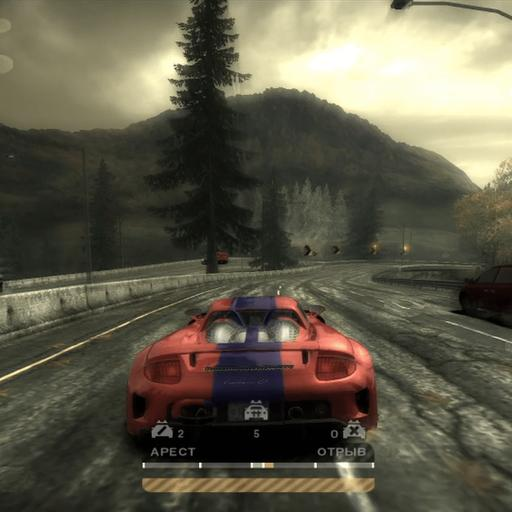
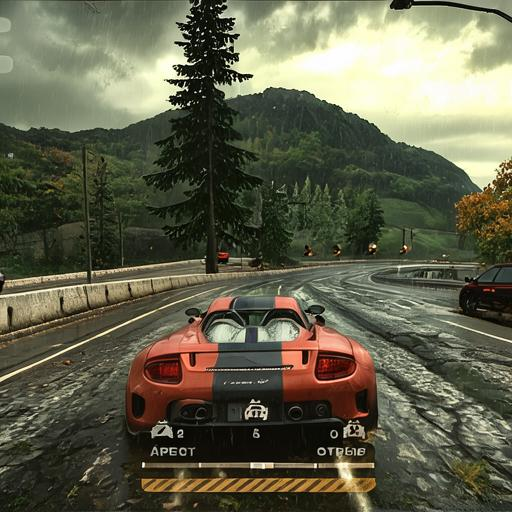

In [7]:
compare(
    # target_tensor,
    source_tensor,
    image,
    cmap="gray",
    start_mode="horizontal",
    start_slider_pos=0.73,
)

In [12]:
weight_dtype

torch.bfloat16

In [13]:
latents.dtype

torch.bfloat16

In [14]:
pipeline.vae.dtype

torch.bfloat16

In [15]:
pipeline.transformer.dtype

torch.float16

In [15]:
pipeline.vae.encode(img_tensor).latent_dist.sample()

KeyError: 'sample'